# Bispectrum function test notebook
Test python implementation of bispectrum function fun_compute_bispectrum.m by Kevin Martins.

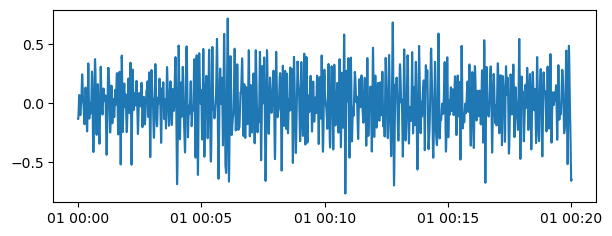

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import detrend, windows
import matplotlib.pyplot as plt
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import transfer_functions as rptf

# Load test data from RBR SoloD pressure sensor
data_root = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
datadir = os.path.join(data_root, 'RBRDuetDT', 'Level1', 'netcdf')
fn = os.path.join(datadir, 'Asilomar_2022_SSA_L1_RBRDuetDT_210358_pressure.nc')
dsp = xr.decode_cf(xr.open_dataset(fn, decode_coords='all'))

# Sampling frequency
fs = 16

# Read/take out test sample (hydrostatic surface)
outdir = '/home/mikapm/Github/Martins_pressure_reconstruction/data'
fn_test = os.path.join(outdir, 'test_data.csv')
if not os.path.isfile(fn_test):
    dt = 0.0625
    t0 = pd.Timestamp('2022-07-01 00:00:00.000000')
    t1 = pd.Timestamp('2022-07-01 00:20:00.000000') - pd.Timedelta(seconds=dt)
    dsp = dsp.sel(time=slice(t0, t1))
    # Make regularly spaced time index
    time_reg = pd.date_range(t0, t1, freq='62500U')
    # Remove possible duplicate samples
    dsp = dsp.sel(time=~dsp.get_index("time").duplicated())
    # Reindex dataset to regular time index
    dsp = dsp.reindex(time=time_reg, method='nearest')
    # Compute (and detrend) hydrostatic surface
    h0 = dsp.z_hyd.mean().item() # Mean water depth
    eta_hyd = detrend(dsp.z_hyd - h0)

    # Save test data in csv format
    dfe = pd.DataFrame(data={'eta_hyd':eta_hyd, 'z_hyd':dsp.z_hyd.values}, 
                       index=time_reg)
    dfe.index = dfe.index.rename('time')
    dfe.to_csv(fn_test)
else:
    dfe = pd.read_csv(fn_test, parse_dates=['time']).set_index('time')
    h0 = dfe['z_hyd'].mean().item()
    eta_hyd = dfe['eta_hyd'].values.squeeze()

# Quick check by plotting eta_hyd
fig, ax = plt.subplots(figsize=(7,2.5))
ax.plot(dfe.index, eta_hyd)
plt.show()

In [4]:
# Compute spectrum and estimate peak frequency
dss = rpws.spec_uvz(eta_hyd, fs=16)

# Compute shallowness and nonlinearity parameters
fp = 1 / dss.Tp_Y95.item() # Peak frequency following Young (1995)
kp = rptf.waveno_full(2*np.pi*fp, d=h0).item()
mu = (kp * h0)**2
mu_info = 'Shallowness parameter'
eps = 2 * np.nanstd(eta_hyd) / h0
eps_info = 'Nonlinear "amplitude" parameter'
Ur = eps / mu
Ur_info  = 'Ursell parameter'
print('h0={:.4f}, kp={:.4f}, mu={:.4f}, eps={:.4f}, Ur={:.4f}'.format(h0, kp, mu, eps, Ur))

# Nonlinear moderately dispersive reconstruction 
nfft = 512 * fs
overlap  = 75
mg_bis   = 5
x = eta_hyd.copy()
lx = len(x)
wind = 'rect'

# Bispectrum calculation
overlap = min(99, max(overlap, 0))
nfft -= np.remainder(nfft, 2)
eadvance = int(np.fix(nfft * overlap / 100))
nadvance = int(nfft - eadvance)
nblock   = int(np.fix((lx - eadvance) / nadvance) + 1) # +1 for not throwing any data out
print('overlap={}, nfft={}, eadvance={}, nadvance={}, nblock={}'.format(
    overlap, nfft, eadvance, nadvance, nblock))

freqs = np.arange(-nfft/2, nfft/2) / nfft * fs
df = freqs[1] - freqs[0]

# Initialize arrays
P = np.zeros(nfft+1) # Power spectrum [m^2]
B = np.zeros((nfft+1, nfft+1)).astype(complex) # Bispectrum [m^3]

# Initialization
A = np.zeros((nfft+1, nblock)).astype(complex) # Fourier coeffs for each block
nmid = int(nfft / 2) # Middle frequency index (f = 0)
locseg = np.arange(nfft) # Indices for first block

# Computing FFT (loop over blocks)
for kk in range(nblock-2):
    # print('kk: ', kk)
    # Preparing block kk timeseries
    # For the rectangular window, we force a certain continuity between blocks
    xseg = x[locseg]
    xseg = detrend(xseg) # Detrend
    xseg -= np.mean(xseg) # De-mean
    if wind == 'rect':
        # Trying to make it periodic
        count = 0
        while abs(xseg[-1]-xseg[0]) > 0.2*np.std(xseg):
            # Updating locseg
            if kk == 0:
                locseg += 1
            else:
                locseg -= 1
            # Updating xseg
            xseg = x[locseg]
            count += 1
        if count > 1:
            xseg = detrend(xseg) # Detrend
            xseg -= np.mean(xseg) # De-mean
        # Smoothing both the timeseries' head and tail
        beg_ts = xseg[:2*fs] 
        end_ts = xseg[-2*fs:]
        merged_ts0 = np.concatenate([end_ts, beg_ts])
        merged_ts = merged_ts0.copy()
        dti = int(np.round(fs/8))
        for tt in range(dti, len(merged_ts)-dti-1):
            merged_ts[tt] = np.mean(merged_ts0[tt-dti:tt+dti+1])
            # print('m: ', merged_ts0[tt-dti:tt+dti+1])
        xseg[:2*fs] = merged_ts[-2*fs:]
        xseg[-2*fs:] = merged_ts[:2*fs]
        
        # Final windowing
        ww = windows.boxcar(nfft) 
        normFactor = np.mean(ww**2)
        xseg *= (ww / np.sqrt(normFactor))

        # FFT of segment
        A_loc = np.fft.fft(xseg , nfft) / nfft
        A[:,kk] = np.concatenate([A_loc[nmid:nfft], A_loc[:nmid+1]]) # FFTshift
        A[nmid,kk] = 0

        # Indices for next block
        locseg += nadvance
    
# Last block, to not throw out data
kk = nblock - 1
locseg = np.arange(len(x)-nfft,len(x))
xseg = x[locseg]
xseg = detrend(xseg)
xseg -= np.mean(xseg)
if wind == 'rect':
    # Trying to make it periodic
    count = 0
    while abs(xseg[-1]-xseg[0]) > 0.2*np.std(xseg):
        # Updating locseg
        locseg -= 1
        # Updating xseg
        xseg = x[locseg]
        count += 1
    if count > 1:
        xseg = detrend(xseg)
        xseg -= np.mean(xseg)
    # Smoothing both the timeseries' head and tail
    beg_ts = xseg[:2*fs] 
    end_ts = xseg[-2*fs:]
    merged_ts0 = np.concatenate([end_ts, beg_ts])
    merged_ts = merged_ts0.copy()
    dti = int(np.round(fs/8))
    for tt in range(dti, len(merged_ts)-dti-1):
        merged_ts[tt] = np.mean(merged_ts0[tt-dti:tt+dti+1])
    xseg[:2*fs] = merged_ts[-2*fs:]
    xseg[-2*fs:] = merged_ts[:2*fs]
    
    # Final windowing
    ww = windows.boxcar(nfft) 
    normFactor = np.mean(ww**2)
    xseg *= (ww / np.sqrt(normFactor))

    # FFT of segment
    A_loc = np.fft.fft(xseg , nfft) / nfft
    A[:,kk] = np.concatenate([A_loc[nmid:nfft], A_loc[:nmid+1]]) # FFTshift
    A[nmid,kk] = 0

#  ------------------- Bispectrum computation ---------------------
# Deal with f1 + f2 = f3 indices
ifr1, ifr2 = np.meshgrid(np.arange(nfft+1), np.arange(nfft+1))
ifr3 = nmid + (ifr1-nmid) + (ifr2-nmid) 
ifm3val = np.logical_and((ifr3 >= 0), (ifr3 < nfft+1))
ifr3[~ifm3val] = 0

# Accumulating triple products (loop over blocks)
for kk in range(nblock):
    # Block kk FFT
    A_loc  = A[:,kk]
    CA_loc = np.conj(A[:,kk])
    # Compute bispectrum and PSD
    B += A_loc[ifr1] * A_loc[ifr2] * CA_loc[ifr3]
    P += np.abs(A_loc**2)

# Expected values
B /= nblock
B[~ifm3val] = 0
P /= nblock

#  ------------------- Skewness and asymmetry ---------------------
#  Notes: 
#         Computation following Elgar and Guza (1985)
#         Observations of bispectra of shoaling surface gravity wave
#         Journal of Fluid Mechanics, 161, 425-448

# We work only in one frequency quadrant
ifreq  = np.arange(nmid, nmid+int((nfft)/2))
sumtmp = 6 * B[nmid, nmid] # Initialisation with first diagonal term

# Loop over frequencies 
for ii, indf in enumerate(ifreq[1:]):
    # Diagonal
    sumtmp += 6 * B[indf, indf]
    # Non-diagonal
    sumtmp += 12 * np.sum(B[indf, np.arange(nmid, indf)])

# Skewness & asymmetry parameters
Sk = np.real(sumtmp) / np.mean((x-np.mean(x))**2)**(3/2)
As = np.imag(sumtmp) / np.mean((x-np.mean(x))**2)**(3/2)
print('Sk={}, As={}'.format(Sk, As))

# ------------------- Merging over frequencies -------------------
# Initialization
mg = int(mg_bis - np.remainder(mg_bis+1, 2))
mm = int((mg - 1) / 2) # Half-window for averaging
nmid = int(nfft/2) # Middle frequency (f = 0)
ifrm = np.concatenate([np.arange(nmid,1+mm-mg,-mg)[::-1], 
                       np.arange(nmid+mg, nfft+1-mm, mg)]) # Frequency indices
Bm = np.zeros((len(ifrm), len(ifrm))).astype(complex) # Merged bispectrum (unit m^3)
Pm = np.zeros(len(ifrm)) # Merged PSD (unit m^2)

# Remove half of diagonals
for ff in range(len(ifreq)):
    B[ff,ff] = 0.5 * B[ff,ff]

# Loop over frequencies
for jfr1 in range(len(ifrm)):
    # Rows
    ifb1 = ifrm[jfr1] # mid of jfr1-merge-block
    # PSD
    Pm[jfr1] = np.sum(P[np.arange(ifb1-mm, ifb1+mm)])
    # Columns for bispectrum
    for jfr2 in range(len(ifrm)):
        ifb2 = ifrm[jfr2] # mid of jfr2-merge-block
        Bm[jfr1,jfr2] = np.sum(np.sum(B[np.arange(ifb1-mm, ifb1+mm), 
                                        np.arange(ifb2-mm, ifb2+mm)]))

# Updating arrays
freqs = freqs[ifrm]
df = np.abs(freqs[1]-freqs[0])


h0=6.0434, kp=0.1067, mu=0.4160, eps=0.0753, Ur=0.1810
overlap=75, nfft=8192, eadvance=6144, nadvance=2048, nblock=7


/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/ma/core.py:2826: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/tmp/ipykernel_1317295/990337108.py:3: UserWarning: Log scale: values of z <= 0 have been masked
  cs = ax.contourf(freqs, freqs, Bm, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


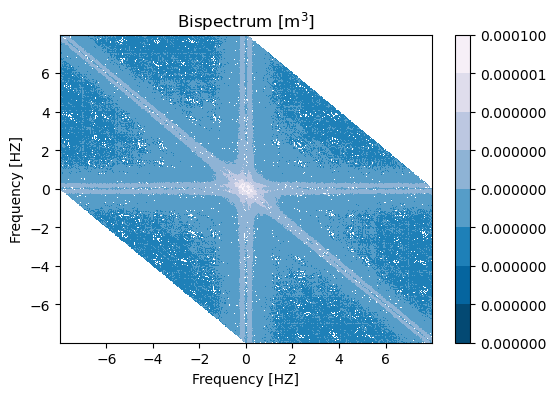

In [4]:
from matplotlib import ticker, cm
fig, ax = plt.subplots(figsize=(6,4))
cs = ax.contourf(freqs, freqs, np.real(Bm), locator=ticker.LogLocator(), 
                 cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
ax.set_xlabel('Frequency [HZ]')
ax.set_ylabel('Frequency [HZ]')
ax.set_title(r'Bispectrum [$\mathrm{m}^3$]')
plt.show()
# plt.clf()

In [2]:
# Test bispectrum() function in roxsi_pyfuns.wave_spectra
dsb = rpws.bispectrum(eta_hyd, fs=16, h0=h0, timestamp=dfe.index[0].round('20T'))

h0=6.0434, kp=0.1067, mu=0.4160, eps=0.0753, Ur=0.1810
overlap=75, nfft=8192, eadvance=6144, nadvance=2048, nblock=7


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['freq', 'freq'], array([4.22653633e-10, 7.34598875e-10, 7.28453046e-10, ...,
       1.42007998e-09, 9.10102256e-10, 7.94038659e-10])) to Variable.

In [3]:
freqs.shape

NameError: name 'freqs' is not defined